# 0. Overview

The problem statement is to determine whether a loan will default, as well as the loss incurred if it does default. Unlike traditional finance-based approaches to this problem, where one distinguishes between good or bad counterparties in a binary way, we seek to anticipate and incorporate both the default and the severity of the losses that result. In doing so, we are building a bridge between traditional banking, where we are looking at reducing the consumption of economic capital, to an asset-management perspective, where we optimize on the risk to the financial investor.

This competition is sponsored by researchers at Imperial College London.

The Dataset Contains two files:

* `train_v2.csv` - This is the training set of shape (105471, 771)

* `test_v2.csv` - This is the test set of shape (210944, 770)

# 1. Environment Set-up and Dataset downloading

In [2]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c loan-default-prediction

 97% 387M/398M [00:04<00:00, 119MB/s]
100% 398M/398M [00:04<00:00, 88.1MB/s]
 95% 174M/183M [00:02<00:00, 57.9MB/s]
100% 183M/183M [00:02<00:00, 84.4MB/s]
  0% 0.00/457k [00:00<?, ?B/s]
100% 457k/457k [00:00<00:00, 133MB/s]


In [3]:
!mkdir datasets
!unzip /content/test_v2.csv.zip -d /content/datasets/
!unzip /content/train_v2.csv.zip -d /content/datasets/

Archive:  /content/test_v2.csv.zip
  inflating: /content/datasets/test_v2.csv  
Archive:  /content/train_v2.csv.zip
  inflating: /content/datasets/train_v2.csv  


# 2. Necessary Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import norm
%matplotlib inline

In [3]:
# To stop warning from showing
import warnings
warnings.filterwarnings('ignore')

# 3. Preprocessing

## 3.1 Data-set Loading

In [4]:
train = pd.read_csv('/content/datasets/train_v2.csv')
test = pd.read_csv('/content/datasets/test_v2.csv')

train.shape, test.shape

((105471, 771), (210944, 770))

In [5]:
train.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,1,-0.40,-0.560,-0.440,-0.6280,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,1,-0.17,-0.275,-0.203,-0.2300,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,...,-6.35,14,56.62,-79.48,621.97,1.9592,-0.3632,3.2969,7.2072,5.7062,4.5627,0.226336,3.3277,3.4166,1.8321,0.9979,0.103307,6.8623,5.2963,4.1282,0.219729,8.1381,7.3269,-0.1909,1,-0.58,-0.540,-0.572,-0.3985,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,...,3.75,5,36.31,18.15,429.81,2.5883,-0.8812,1.2950,2.5777,2.0830,1.6899,0.054630,1.3748,1.3421,0.7982,0.4810,0.081205,2.5571,2.0593,1.6653,0.056470,3.2516,3.0631,-0.1770,1,-0.75,-0.635,-0.745,-0.5100,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,...,11.45,27,2206.14,-10559.05,708436.49,9.0293,-0.8760,6.3852,17.2599,14.2795,11.9179,0.085330,7.2175,6.2262,3.1446,1.6149,0.074286,15.9080,12.5688,9.9844,0.067540,17.5561,15.6079,-0.4444,1,-0.18,-0.280,-0.182,-0.4277,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [6]:
len_test = len(train)
train = train.append(test)

test = None
train.shape, len_test

((316415, 771), 105471)

## 3.2 Feature Engineering and Data Cleaning

In [7]:
# Function to handle missing values in a column

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        return mis_val_table_ren_columns

In [8]:
train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [9]:
cols_object = train.select_dtypes(include=['object']).columns
cols_int = train.select_dtypes(include=['int']).columns
cols_float = train.select_dtypes(include=['float']).columns

In [10]:
unable_to_convert = []
for col in cols_object:
  try:
    train[col] = train[col].astype(str).astype(float)
  except:
    unable_to_convert.append(col)

In [11]:
len(unable_to_convert), unable_to_convert

(2, ['f137', 'f276'])

In [12]:
for i in unable_to_convert:
  train[i] = train[i].replace('NA', np.nan)
  train[i] = train[i].astype(str).astype(float)

In [13]:
train.shape

(316415, 771)

In [14]:
cols_to_drop = missing_values_table(train)

In [15]:
cols_to_drop = list(cols_to_drop[cols_to_drop['% of Total Values']>=15].index.values)

try:
  cols_to_drop.remove('id')
except:
  pass

try:
  cols_to_drop.remove('loss')
except:
  pass

len(cols_to_drop)

12

In [16]:
# Droping the columns with more than 15% of NA data -> around 48k datapoints
train = train.drop(cols_to_drop, axis=1)
train.shape

(316415, 759)

In [19]:
# cat = list(cols_object.values)
# cat.append(list(cols_int.values))
# cat = [x for x in cat if x not in cols_to_drop]
# cols_float = [x for x in cols_float if x not in cols_to_drop]
# len(cat), len(cols_float)

In [17]:
# Function to check if the values in a column are all same
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

    

# Function to find out duplicate columns
# reference: https://www.geeksforgeeks.org/how-to-find-drop-duplicate-columns-in-a-pandas-dataframe/

def getDuplicateColumns(df):
    duplicateColumnNames = set() 
    for x in range(df.shape[1]): 
        col = df.iloc[:, x] 
        for y in range(x + 1, df.shape[1]): 
            otherCol = df.iloc[:, y] 
            if col.equals(otherCol): 
                duplicateColumnNames.add(df.columns.values[y]) 
    return list(duplicateColumnNames) 

In [18]:
column = train.columns #get all column names

In [19]:
#get columns which has same value across all rows

check_columns = []

for i in column:
    check_columns.append(is_unique(train[i]))

n = check_columns.index(True)

same_value_column = column[n]

same_value_column

'f33'

In [20]:
#get all duplicate columns in the dataframe
duplicate_columns = getDuplicateColumns(train)

duplicate_columns

['f38', 'f34', 'f702', 'f37', 'f35', 'f701', 'f764', 'f700']

In [21]:
# Dropping all duplicate columns and column with same value in all row

# Dropping column which has same value accross all rows

train = train.drop(same_value_column, axis = 1)

# Dropping all the duplicate columns

train = train.drop(duplicate_columns, axis = 1)

# Check shape
train.shape

(316415, 750)

In [22]:
# # We will be using 'mode' to impute missing values in columns which are categorical in nature
# train[cat].fillna(train[cat].mode())

# # We will be using 'median' to impute missing values in columns which are continuous in nature
# train[cols_float].fillna(train[cols_float].mode())

In [23]:
column_act = list(train.columns.values)
column_act.remove('loss')

In [24]:
train[column_act] = train[column_act].fillna(train[column_act].median())

# 3.3 Target Analysis

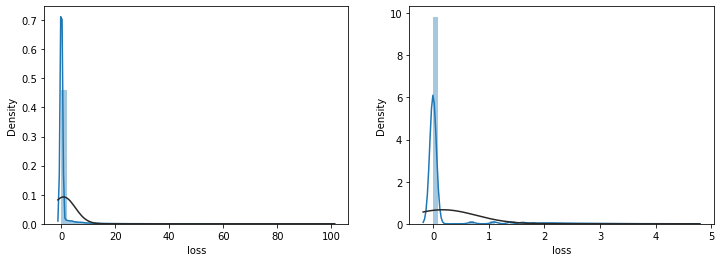

In [25]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sn.distplot(train['loss'][:len_test], ax=ax[0], fit=norm)
sn.distplot(np.log(train['loss'][:len_test].astype('int64')+1), ax=ax[1], fit= norm)

## 3.4 Analyzing Correlation

In [26]:
corr = train[:len_test].corr()['loss'].sort_values()

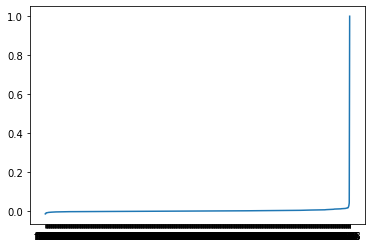

In [27]:
plt.plot(corr)

In [49]:
train.shape[1] -  (sum(i < 0.004 and i > -0.005 for i in corr)/len(corr))*train.shape[1]

138.0

In [50]:
# To find all the columns with low correlation

get_low_corr = []
col = train.select_dtypes(include=['float','int']).columns
for i in col:
  val = train['loss'].corr(train[i])
  if(val <= 0.004) and (val >= -0.005):
    get_low_corr.append(i)

get_low_corr.remove('id')

len(get_low_corr)

611

In [52]:
train = train.drop(get_low_corr, axis = 1)
train.head(5)

,id,f1,f4,f9,f10,f13,f18,f19,f31,f39,f40,f41,f45,f47,f49,f51,f55,f56,f57,f59,f61,f65,f67,f68,f69,f70,f102,f103,f178,f190,f200,f211,f221,f222,f231,f232,f238,f241,f251,f252,...,f632,f641,f642,f643,f660,f665,f666,f667,f670,f674,f675,f676,f678,f696,f699,f716,f728,f730,f731,f732,f734,f736,f737,f738,f740,f742,f753,f754,f755,f765,f766,f767,f769,f771,f772,f773,f774,f775,f776,loss
0,1,126,1100,126.75,126.03,7,0.7236,0.5171,89.0,0.73180,0.72124,0.749280,0.83380,0.825920,0.75710,0.767820,0.53855,0.52539,0.551920,0.79380,0.794880,0.960160,4.5785,6,-0.01,0.00,0.01,0.00,0.46,1.05,1.15,6.39,0.02,0.0,0.13,0.01,0.30,0.01,0.15,0.01,...,0.929,0.762765,0.750977,0.781186,1.14,227.0,3.0,17211.0,335,33,3.0,0.60,0.0,0.186912,11748,1.354874,768,98316,12587508,1611786276,-2.00,1,-1.60,-2.020,-4.40,9.76,1.5271,0.8474,0.4715,-0.40,-0.560,-0.440,-3.14,2.14,-1.54,1.18,0.1833,0.7873,1,0.0
1,2,121,1100,123.52,121.35,7,0.6341,0.3909,78.0,0.65705,0.64069,0.626200,0.72515,0.687067,0.67775,0.642050,0.42545,0.41181,0.393817,0.71515,0.669100,0.793950,4.5785,6,-0.04,-0.03,0.01,0.00,0.25,1.61,1.37,8.99,0.04,0.0,0.01,0.00,0.25,0.01,0.04,0.00,...,6.548,0.741765,0.749177,0.679880,1.15,233.0,4.0,13597.0,335,43,10.0,0.83,0.0,0.191660,336,0.832299,881,110953,13982483,1763226997,-4.86,1,-2.73,-4.594,0.35,51.73,1.0322,0.4843,0.2389,-0.17,-0.275,-0.203,-1.38,0.54,-0.24,0.13,0.1926,-0.6787,1,0.0
2,3,126,1100,127.76,126.49,7,0.7542,0.5508,89.0,0.74710,0.75878,0.654685,0.80455,0.709346,0.74710,0.656654,0.54540,0.55572,0.502138,0.78035,0.692523,0.798423,4.5785,6,-0.03,-0.04,0.26,0.09,0.30,1.37,1.17,10.88,0.01,0.0,0.02,0.00,0.26,0.01,0.02,0.00,...,11.148,0.792410,0.786338,0.723983,1.12,689.0,10.0,47657.0,335,100,5.0,0.42,0.0,0.252978,14500,1.665038,1787,228163,29139977,3722679463,-1.64,1,0.12,-1.166,-6.35,56.62,3.4166,1.8321,0.9979,-0.58,-0.540,-0.572,-5.18,2.89,-1.73,1.04,0.2521,0.7258,1,0.0
3,4,134,1100,132.94,133.58,7,0.7881,0.5923,93.0,0.77405,0.78929,0.750675,0.81150,0.800900,0.77405,0.761825,0.58615,0.59307,0.573525,0.80790,0.797550,0.928550,4.5785,6,0.02,0.03,0.07,0.00,0.29,1.17,1.05,7.97,0.04,0.0,0.02,0.00,0.29,0.01,0.06,0.00,...,1.496,0.906675,0.930015,0.884525,-0.62,62.0,1.0,3844.0,335,18,2.0,0.25,0.0,0.250200,2462,1.498953,665,88503,11786291,1570641075,1.00,1,0.16,0.590,3.75,36.31,1.3421,0.7982,0.4810,-0.75,-0.635,-0.745,-2.04,1.29,-0.89,0.66,0.2498,0.7119,1,0.0
4,5,109,2900,122.72,112.77,6,0.5263,0.3044,60.0,0.60315,0.53367,0.696150,0.71780,0.810285,0.61315,0.715869,0.37220,0.31396,0.483685,0.66275,0.779285,0.870969,4.9649,6,-0.20,-0.26,0.01,0.00,0.15,1.58,1.51,8.23,0.01,0.0,0.02,0.00,0.20,0.01,0.02,0.00,...,18.154,0.678565,0.625417,0.747705,1.37,1281.0,24.0,70703.0,381,33,9.0,0.82,0.0,0.230740,52838,0.826984,3415,434277,55511449,7130863233,-17.48,1,-3.91,-13.762,11.45,2206.14,6.2262,3.1446,1.6149,-0.18,-0.280,-0.182,-11.12,6.11,-3.82,2.51,0.2282,-0.5399,0,0.0


# 4. Model development

## 4.1 Dataset splitting and dataset development to fit in the model

In [54]:
temp = train[train['loss'].notnull()]
test = train[train['loss'].isnull()]
train = temp
temp = None
X,y = train.drop(['loss'],axis=1),train['loss'].values

X.shape, y.shape, train.shape, test.shape

((105471, 138), (105471,), (105471, 139), (210944, 139))

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

X_train.shape, X_test.shape, X_val.shape

((67500, 138), (21095, 138), (16876, 138))

## 4.2 Model Training

In [78]:
import time
from xgboost import XGBRegressor
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="mae", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts


[10:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.22027	validation_1-mae:1.24198
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:1.23692	validation_1-mae:1.26157
[2]	validation_0-mae:1.24949	validation_1-mae:1.27969
[3]	validation_0-mae:1.25911	validation_1-mae:1.29382
[4]	validation_0-mae:1.26976	validation_1-mae:1.30873
[5]	validation_0-mae:1.27938	validation_1-mae:1.3233
[6]	validation_0-mae:1.28735	validation_1-mae:1.33671
[7]	validation_0-mae:1.29166	validation_1-mae:1.34969
[8]	validation_0-mae:1.29893	validation_1-mae:1.36119
[9]	validation_0-mae:1.30197	validation_1-mae:1.36939
[10]	validation_0-mae:1.30566	validation_1-mae:1.37646
[11]	validation_0-mae:1.30868	validation_1-mae:1.385
[12]	validation_0-mae:1.3106	validation_1-mae:1.39067
[13]	validation

27.574599504470825

# 5. Evaluation and Generating submission dataset

In [67]:
test = test.drop(['loss'], axis = 1)
pred = model.predict(test)

In [68]:
sub = pd.DataFrame()

sub['id'] = test['id']
sub['loss'] = pred

In [69]:
sub.head(5)

,id,loss
0,105472,1.012652
1,105473,0.729677
2,105474,0.590680
3,105475,0.506333
4,105476,0.928455


In [70]:
sub.to_csv('submission.csv', index = False)